In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from data_reader import read_consumption_and_weather
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [106]:
df = read_consumption_and_weather()[-1]

df_no1 = df['NO1']
df_no1.loc[:,'region'] = 1

df_no2 = df['NO2']
df_no2.loc[:,'region'] = 2

df_no3 = df['NO3']
df_no3.loc[:,'region'] = 3

df_no4 = df['NO4']
df_no4.loc[:,'region'] = 4

df_no5 = df['NO5']
df_no5.loc[:,'region'] = 5

# combine all dataframes into one
df = pd.concat([df_no1, df_no2, df_no3, df_no4, df_no5])


# datetime features
dates = df.index
df['time_of_day'] = df.index.hour
df['time_of_week'] = df.index.dayofweek
df['time_of_month'] = df.index.day
df['time_of_year'] = df.index.month


df['consumption_24h_lag'] = df['consumption'].shift(24)#fillna(method='bfill')
df = df.dropna()
df['consumption_yday_mean'] = df['consumption'].shift(24).rolling(24).mean()#fillna(method='bfill')
df = df.dropna()
df['consumption_prev'] = df['consumption'].shift(1)#fillna(method='bfill')
df = df.dropna()
df.head()


Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,consumption,temperature,region,time_of_day,time_of_week,time_of_month,time_of_year,consumption_24h_lag,consumption_yday_mean,consumption_prev
2017-05-04 00:00:00+00:00,2729.629003,9.5,1,0,3,4,5,2870.407999,3623.894460,2776.312998
2017-05-04 01:00:00+00:00,2782.087997,9.3,1,1,3,4,5,2885.274001,3608.622501,2729.629003
2017-05-04 02:00:00+00:00,2825.548003,7.9,1,2,3,4,5,2887.499001,3590.076751,2782.087997
2017-05-04 03:00:00+00:00,2951.974004,7.2,1,3,3,4,5,2951.849002,3567.845918,2825.548003
2017-05-04 04:00:00+00:00,3426.861001,6.4,1,4,3,4,5,3416.992002,3543.477001,2951.974004


In [107]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# # scale temperature and consumption
# df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']] = \
#     scaler.fit_transform(df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']])
# df.head()

In [108]:
std = df.std()
mean = df.mean()

df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']] = \
    ((df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']])\
     -mean[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']])\
        /std[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']]


In [109]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.show()

In [110]:
df = df[['temperature', 'consumption', 'consumption_24h_lag', 'region', 'time_of_day', 'time_of_week', 'time_of_year', 'consumption_yday_mean']]
#df = df[['temperature', 'consumption']]
df.head()

,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean
2017-05-04 00:00:00+00:00,0.298004,-0.287242,-0.167486,1,0,3,5,0.484086
2017-05-04 01:00:00+00:00,0.270654,-0.242583,-0.154830,1,1,3,5,0.470806
2017-05-04 02:00:00+00:00,0.079207,-0.205584,-0.152936,1,2,3,5,0.454679
2017-05-04 03:00:00+00:00,-0.016516,-0.097955,-0.098152,1,3,3,5,0.435348
2017-05-04 04:00:00+00:00,-0.125915,0.306326,0.297840,1,4,3,5,0.414158


In [111]:
target_feature = 'consumption'
#features = list(df.columns.difference([target_feature])) #kanskje bruk denne istedenfor
features = list(df.columns)
print("features: ", len(features))
forecast_lead = 1
target = f"{target_feature}_lead{forecast_lead}"

df[target] = df[target_feature].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

df.tail()

features:  8


,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean,consumption_lead1
2023-01-21 18:00:00+00:00,-0.713931,-0.607124,-0.515053,5,18,5,1,-0.620048,-0.652882
2023-01-21 19:00:00+00:00,-0.686582,-0.652882,-0.545197,5,19,5,1,-0.617882,-0.689798
2023-01-21 20:00:00+00:00,-0.659232,-0.689798,-0.584647,5,20,5,1,-0.616537,-0.722067
2023-01-21 21:00:00+00:00,-0.618208,-0.722067,-0.624719,5,21,5,1,-0.615343,-0.755023
2023-01-21 22:00:00+00:00,-0.577183,-0.755023,-0.657087,5,22,5,1,-0.613730,-0.793910


In [112]:
validation_start = "2022-01-01"
test_start = "2022-06-20"

df_train = df.loc[:validation_start].copy()
df_val = df.loc[validation_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.10327652639590065


In [113]:
df_train.tail()

,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean,consumption_lead1
2022-01-01 19:00:00+00:00,0.188606,-0.830845,-0.867396,5,19,5,1,-0.871711,-0.868670
2022-01-01 20:00:00+00:00,0.215955,-0.868670,-0.896306,5,20,5,1,-0.875123,-0.901801
2022-01-01 21:00:00+00:00,0.243305,-0.901801,-0.917648,5,21,5,1,-0.877757,-0.940104
2022-01-01 22:00:00+00:00,0.270654,-0.940104,-0.938137,5,22,5,1,-0.879324,-0.973387
2022-01-01 23:00:00+00:00,0.311679,-0.973387,-0.951825,5,23,5,1,-0.879796,-1.004412


In [114]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=24):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.Tensor(dataframe[target].values).float()
        self.X = torch.Tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if idx >= self.sequence_length - 1:
            i_start = idx - self.sequence_length + 1
            x = self.X[i_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[idx]

In [115]:
torch.manual_seed(42)

batch_size = 32
sequence_length = 24

train_dataset = SequenceDataset(
    df_train, 
    target = target, 
    features = features, 
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_val,
    target = target,
    features = features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target = target,
    features = features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([32, 24, 8])
Target shape: torch.Size([32])


In [116]:
# bytt ut denne da vettu!
class CNNModel(nn.Module):
    def __init__(self, tw, num_features, use_cuda=False):
        super().__init__()
        self.tw = tw
        self.num_features = num_features

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=tw, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2), # 128

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2), # 64
        )

        self.linear = nn.Sequential(
        nn.Linear(in_features=64, out_features=32),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=32, out_features=1)
        )

        if use_cuda:
            self.to(device = torch.device('cuda'))


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size, -1)
        x = self.linear(x).flatten()
        return x


gpu: True
0 - train: 0.016104422036040553, valid: 0.006868335942816094
1 - train: 0.004685515659913079, valid: 0.004539688789094233
2 - train: 0.0032980978811943257, valid: 0.0038652065328998357
3 - train: 0.0026488636445483244, valid: 0.0016019298001250537
4 - train: 0.00225420402338146, valid: 0.0025742682882198757
5 - train: 0.0019793711361006426, valid: 0.0016103873488665893
6 - train: 0.0018587266478576477, valid: 0.0015190434720108977
7 - train: 0.0017274054045253932, valid: 0.0012981775894487636
8 - train: 0.0015957214320970483, valid: 0.0011878097990188296
9 - train: 0.001537987208044259, valid: 0.0016854931223220728


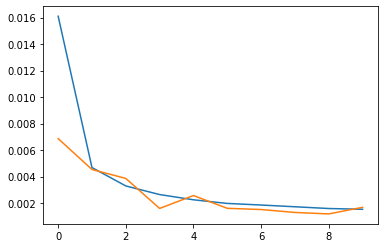

In [117]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"gpu: {USE_CUDA}")
model = lr = 5e-5

model = CNNModel(tw=24, num_features=len(features), use_cuda=USE_CUDA).to(device)

lr = 4e-4
n_epochs = 10
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


t_losses, v_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = 0.0, 0.0

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.squeeze().to(device)
        #print(f"x shape: {x.shape}, y shape: {y.shape}")
        #print(x)
        preds = model(x)#.squeeze()
        #print(f"preds shape: {preds.shape}")
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_loader)
    t_losses.append(epoch_loss)

    # validation
    model.eval()
    for x, y in val_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        val_loss += error.item()
    val_loss = val_loss / len(val_loader)
    v_losses.append(val_loss)

    print(f'{epoch} - train: {epoch_loss}, valid: {val_loss}')

plot_losses(t_losses, v_losses)


In [118]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
  model.eval()
  predictions, actuals = [], []
  device = next(model.parameters()).device
  for x, y in unshuffled_dataloader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      p = model(x)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).cpu().numpy()
  actuals = torch.cat(actuals).cpu().numpy()
  return predictions.squeeze(), actuals


In [119]:
preds, actuals = make_predictions_from_dataloader(model, test_loader)

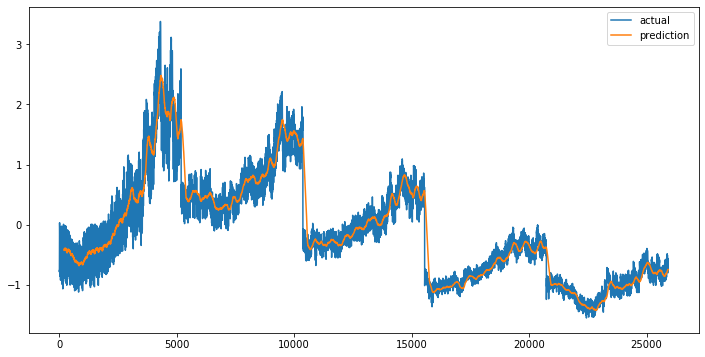

In [120]:
# plot the predictions vs the actuals witht the predictions as an average line
window_size = 200

# calculate the moving average of the predictions
moving_preds = np.convolve(preds, np.ones(window_size)/window_size, mode='valid')

# plot the actuals and smoothed predictions
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='actual')
plt.plot(np.arange(window_size-1, len(preds)), moving_preds, label='prediction')
plt.legend()
plt.show()

In [121]:
def forecast(dataloader, df_to_plot, batch_num:int=0, fw:int=24, plot:bool=True):
    """
    fw: forecast window
    """
    predictions = {i: [] for i in range(len(test_loader))}
    prev_y_ind = 1 # lag of the consumption
    df_start_ind = fw * batch_num # indexes for accessing 
    df_end_ind = fw * (batch_num + 1)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x, y = data
            current_input = x.to(device)
            
            for _ in range(fw):
                # Use the current input to make a prediction
                prediction = model(current_input)

                # Add the prediction to the list of predictions
                predictions[i].append(prediction.cpu().numpy())

                # delete the first timestep from the input and add the forecast to the end
                current_input[:, :-1, prev_y_ind] = current_input[:, 1:, prev_y_ind]
                current_input[:, -1, prev_y_ind] = torch.from_numpy(prediction.cpu().numpy()).to(device) 

    targets_to_plot = df_to_plot.iloc[df_start_ind:df_end_ind]['consumption_lead1'].reset_index(drop=True)
    preds_to_plot = pd.Series(np.array(predictions[batch_num]).squeeze()[:,0])
    res_df = pd.concat([targets_to_plot, preds_to_plot], axis=1)
    res_df.rename(columns={"consumption_lead1": "target",
                           0: "pred"}, inplace=True)
    plt.figure(figsize=(12,6))
    plt.plot(res_df.iloc[:,0], label='actual')
    plt.plot(res_df.iloc[:,1], label='pred')
    plt.legend()
    plt.show()
    return res_df

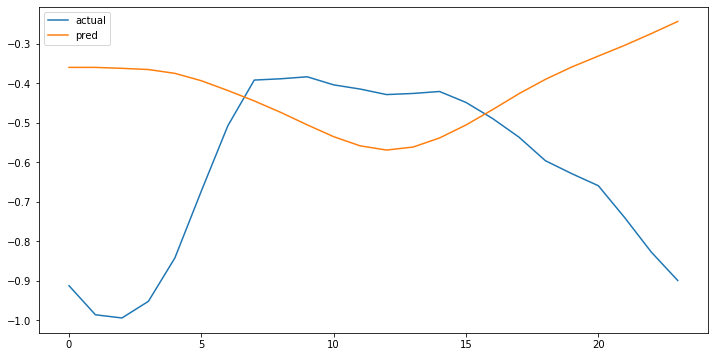

In [127]:
# forecast(test_load, df_test, batch_number, forecast_window, plot)
res = forecast(test_loader, df_test, 5, 24, True)

In [123]:
res[:] = (res[:] * std["consumption"]) + mean["consumption"]

In [124]:
res.head()

,target,pred
0,2108.113195,2967.688965
1,2060.054350,2984.036865
2,2128.031342,2988.618164
3,2428.201749,2994.506348
4,2800.966270,3014.312500


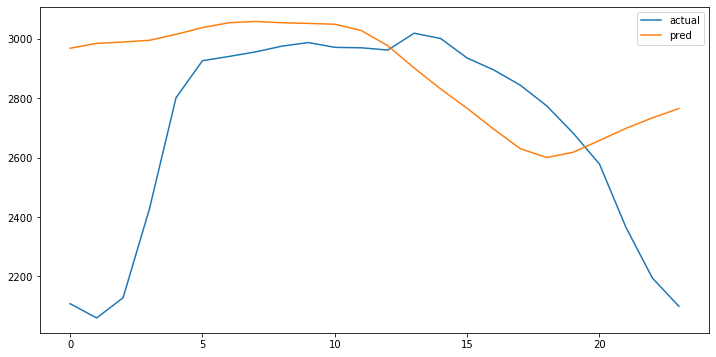

In [125]:
plt.figure(figsize=(12,6))
plt.plot(res.iloc[:,0], label='actual')
plt.plot(res.iloc[:,1], label='pred')
plt.legend()
plt.show()